**Samuel Munoz**

Spring 2021

CS 252: Mathematical Data Analysis and Visualization

Project 3: Linear regression

QR-based linear regression and polynomial regression

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import data
import linear_regression

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Notes

- In your implementations, only the following "high level" `scipy`/`numpy` functions can be used:
    - `np.linalg.inv`
    - `scipy.linalg.lstsq` (in `LinearRegression::linear_regression_scipy` only).
    - `np.linalg.norm`
    - `scipy.linalg.solve_triangular`, 

## Task 4: Implement a QR based linear regression solver

### 4a) QR-decomposition

- Write algorithm to compute QR decomposition (`linear_regression::qr_decomposition`). **Run test code below.** Equation for R: $$R = Q^TA$$
- Implement `linear_regression::linear_regression_qr` to use the QR decomposition to do the linear regression. Recall that the equation is $$Rc = Q^Ty$$ which can be solved without taking the inverse of $R$ through backsolving.

#### Test QR decomposition

In [27]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)

A = iris_data.select_data(['sepal_length', 'petal_width'])
A1 = np.hstack([A, np.ones([len(A), 1])])

lin_reg_qr = linear_regression.LinearRegression(iris_data)
myQ, myR = lin_reg_qr.qr_decomposition(A1)

Q, R = np.linalg.qr(A1)

print('NOTE: It is ok if numbers match but whole columns are negated.\n')
print(f'Your Q shape is {myQ.shape} and should be {Q.shape}')
print(f'Your R shape is {myR.shape} and should be {R.shape}')
print(f'1st few rows of your Q are\n{myQ[:3]} and should be\n{Q[:3]}')
print(f'\nYour R is\n{myR[:5]} and should be\n{R[:5]}')

NOTE: It is ok if numbers match but whole columns are negated.

Your Q shape is (150, 3) and should be (150, 3)
Your R shape is (3, 3) and should be (3, 3)
1st few rows of your Q are
[[ 0.07056 -0.11765  0.00009]
 [ 0.0678  -0.11202  0.0339 ]
 [ 0.06503 -0.10638  0.06772]] and should be
[[-0.07056 -0.11765 -0.00009]
 [-0.0678  -0.11202 -0.0339 ]
 [-0.06503 -0.10638 -0.06772]]

Your R is
[[72.27621 15.60873 12.12709]
 [ 0.       7.66143 -1.22542]
 [ 0.      -0.       1.19668]] and should be
[[-72.27621 -15.60873 -12.12709]
 [  0.        7.66143  -1.22542]
 [  0.        0.       -1.19668]]


#### Test linear regression via QR decomposition

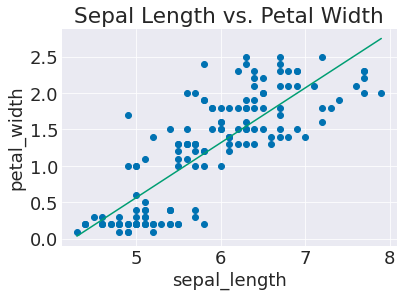

In [32]:
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
lin_reg_qr.scatter('sepal_length', 'petal_width', title='Sepal Length vs. Petal Width')
lin_reg_qr.show()

**Question 4:** How do your results compare to the built-in SciPy solver? Is this what you expected? Why or why not?

**Answer 4:** The two method are identical. This what I would expect because these are two methods that achieve the same end result. Thus, it is not shocking to see identical results.

### Task 4b) Compare performance of the linear regression methods

- In the cell below, load in the brain network `brain.csv` dataset.
- Create `Data` and `LinearRegression` objects.
- Load in the list of variable names in the brain dataset (62)
- Do multiple linear regressions, separately for each of the linear regression methods that you have implemented (including `scipy`): Set all brain data variables except for the last one as the independent variables, the last variable is the depenendent variable.
- Compute and print the mean sum of squares error (MSSE) in the predictions made by each linear regression model and the actual y values.

In [40]:
# load brain data and store it in Data and LinearRegression object
# also store headers of data in variable
brain_data = data.Data("data/brain.csv")
brain_lin = linear_regression.LinearRegression(brain_data)
headers = brain_data.get_headers()

# compute linear regressionfor all methods
brain_lin.linear_regression(headers[:len(headers)-1], headers[len(headers)-1], "scipy")
print("SciPy: MSSE: ", brain_lin.m_sse)
brain_lin.linear_regression(headers[:len(headers)-1], headers[len(headers)-1], "normal")
print("Normal: MSSE: ", brain_lin.m_sse)
brain_lin.linear_regression(headers[:len(headers)-1], headers[len(headers)-1], "qr")
print("QR: MSSE: ", brain_lin.m_sse)

SciPy: MSSE:  8.628592464435679e-26
Normal: MSSE:  10939.68743843348
QR: MSSE:  7.556509786641562e-25


**Question 5:** What are the mean sum of squares errors for each of the regression methods on the brain data? Which method(s) do best and which do the worst **and why**?

**Answer 5:** The mean sum of square error for each method is listed above. The larger the mean sum of square error, the worst it is. The worst error was the normal method. The next best was the QR method. The best method was the SciPy by a small margin. The reason why the normal function computes the worst because the residuals produced by method produce the largest residuals. This is followed by qr decomposition and then scipy method.

## Task 5: Polynomial Regression

We have been creating linear regression fits of form $y =c_0 + c_1x_1 + c_2x_2 + \ldots$, where $x_i$ are independent variables (columns of $A$) and $c_i$ are corresponding coefficients in $c$. However, this equation only allows us to fit data with a line/plane. This may not be the best choice for all datasets.

In this task, you will generalize the linear regression model form to include higher-degree (>1) polynomial terms and explore how this may improve fits to complex data. For example, assume we're doing a simple linear regression with independent variable $x_1$ and dependent variable $y$. A linear regression that fits data with a quadratic shape has the form$$y = c_0 + c_1x_1 + c_2x_1^2$$ 

Complete the following steps to add support for polynomial regression in your `LinearRegression` class.

### 5a) Build the polynomial matrix of the independent variable

The polynomial matrix contains the independent variable raised to a different power in each column. For example, if $A$ originally has a column vector for the independent variable $\vec{x_1}$ ($A = [\vec{x_1}]$) and we wanted to make the above quadratic model, we would append $x_1^2$ ($A = [\vec{x_1}, \vec{x_1^2}]$).

**TODO:**
Implement and test `LinearRegression::make_polynomial_matrix` (*helper method*) that takes care of raising the independent variable samples to different powers.

##### Test `make_polynomial_matrix`

In [22]:
test_A = np.r_[1:10].reshape((9, 1))
test_p = 3

# Test cubic
lin_reg = linear_regression.LinearRegression(data.Data())
print(f'Your polynomial matrix:\n{lin_reg.make_polynomial_matrix(test_A, 3)}')

true_mat = '''
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
'''
print('It should look like:\n', true_mat)

Your polynomial matrix:
[[  1   1   1]
 [  2   4   8]
 [  3   9  27]
 [  4  16  64]
 [  5  25 125]
 [  6  36 216]
 [  7  49 343]
 [  8  64 512]
 [  9  81 729]]
It should look like:
 
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]



### 5b) Add support for polynomial regression

This can be performed in 3 steps:

1. Implement the `LinearRegression::polynomial_regression` method to perform the polynomial regression (*alternate option: you may instead update your `linear_regression` method. If you decide to go this route, add a keyword argument for the polynomial degree with a default value of 1 to preserve compatability with regular linear regression.*).
    - I suggest using your QR solver, but you could use any of the ones you have implemented.
2. Update `LinearRegression::predict`: Run `make_polynomial_matrix` on the "A" matrix that enters into the computation $y = Ac$ if `self.p > 1`.
3. Add support for plotting polynomials in `LinearRegression::scatter` by generalizing the plotted regression line to a regression polynomial if `self.p > 1`:
    - Getting your polynomial "x" values: Run `make_polynomial_matrix` on your evenly-spaced line sample points. To get the shapes to work out, you may need to add a trailing singleton dimension to your "x" sample points. For example, if you have 1000 "x" sample points, make the shape `(1000, 1)` rather than `(1000,)`.
    - Getting your polynomial "y" values: Use matrix multiplication with your polynomial regression model slopes and/or intercepts.

*There is no explicit test code here — visualizing the fit in the next subtask will help you debug!*

### 5c) Run a polynomial regression

In this subtask, you will debug your polynomial regression implementation and experiment fitting some data with it.

#### Test: Polynomial regression with linear model ($p = 1$)

- In the cell below, fit the `poly_data.csv` dataset using polynomial regression where the polynomial degree $p = 1$. Use your QR solver.
- Use `scatter` to plot the results.
- Print out the mean sum of squares error.

The plot created by running the below cell should "look right" to you.

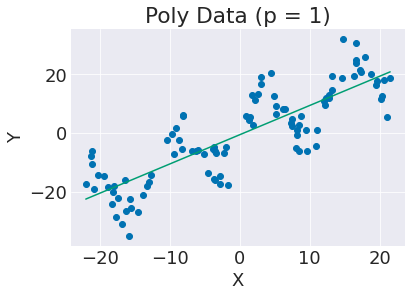

R^2:  0.6932566071471753
R^2:  71.81095284569933


In [23]:
# load poly data and store it in Data and LinearRegression object
# also store headers of data in variable
poly_data = data.Data("data/poly_data.csv")
poly_lin = linear_regression.LinearRegression(poly_data)
headers = poly_data.get_headers()

# run regression
poly_lin.linear_regression([headers[0]], headers[1], method="qr", p=1)

# polot regression
poly_lin.scatter(headers[0], headers[1], title="Poly Data (p = 1)")
plt.show()

# print r^2 and msse
print("R^2: ", poly_lin.R2)
print("R^2: ", poly_lin.m_sse)

#### Test: polynomial regression with high degree polynomials

Repeat the steps from the $p = 1$ test above in the cell below, but this time try $p = 15$. 

*Your regression fit should not be a line!*

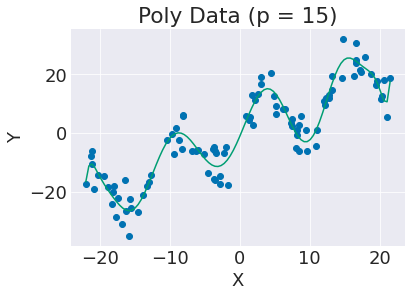

R^2:  0.9319571026199437
R^2:  15.929357922921554


In [24]:
# load poly data and store it in Data and LinearRegression object
# also store headers of data in variable
poly_data = data.Data("data/poly_data.csv")
poly_lin = linear_regression.LinearRegression(poly_data)
headers = poly_data.get_headers()

# run regression
poly_lin.poly_regression([headers[0]], headers[1], 15)

# polot regression
poly_lin.scatter(headers[0], headers[1], title="Poly Data (p = 15)")
plt.show()

# print r^2 and msse
print("R^2: ", poly_lin.R2)
print("R^2: ", poly_lin.m_sse)

**Question 6:** Describe the fit compared to `p=1` — is it better or worse? Why?

**Question 7:** Describe what happens visually and in terms of the $R^2$ and MSE values as you experiment with the polynomial degree between 1 and 15. 

**Answer 6:** The fit of the curve with `p=15` is much better than the curve with `p=1`. This occurs because the higher degrees of the curve with `p=15` can capture some the inflections in the curve. With the curve with `p=1`, this is not possible

**Answer 7:** Visually, as $R^2$ and MSE increases, the regression curve becomes more and more closer to points. This makes the curve look like it has a better fit. Numerically, as polynomial degrees increase, we a better fit curve (to an extent). Thus, $R^2$ increases because the more our regression curve is correctly predicting the values in the data set. MSE decreases because the residuals decrease and as consequence, MSE also decreases.

## Task 6: Overfitting

In this task, you will experiment with how polynomial regression generals to data not used to fit the regression model.

### 6a) Create fit and validation sets

The `poly_data.csv` dataset has 100 samples ($N=100$). In the cell below, split these samples into two separate "datasets" and create 2 `Data` objects representing:
- The first 50% of samples will be used to fit the regression model (i.e. run linear regression on these samples). We will call this the **fit set** (data used to fit the regression).
- The second 50% of samples will be set aside and only used to check how well the fitted regression generalizes to new data. We will call this the **validation set**.

*Hint: There is a helpful `Data` method for paring down a dataset into a certain range of samples.*

In [25]:
# load poly data and store it in Data and LinearRegression object
# also store headers of data in variable
fit = data.Data("data/poly_data.csv")
validate = data.Data("data/poly_data.csv")
fit.limit_samples(0, 50)
validate.limit_samples(50, 100)

print(fit)
print(validate)

----------------------------------------------
data/poly_data.csv (50x2)
Headers:
	X	Y	
----------------------------------------------
Showing first 5/50 rows.
2.147	11.382	
9.465	1.034	
4.52	20.251	
1.974	2.89	
-3.358	-6.809	
----------------------------------------------

----------------------------------------------
data/poly_data.csv (50x2)
Headers:
	X	Y	
----------------------------------------------
Showing first 5/50 rows.
-3.65	-4.658	
9.69	-6.107	
-21.986	-17.271	
-8.694	-2.22	
-15.536	-25.608	
----------------------------------------------



Printing the `Data` object storing the fit set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    2.147	11.382
    9.465	1.034
    4.52	20.251
    1.974	2.89
    -3.358	-6.809

    -------------------------------

Printing the `Data` object storing the validation set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    -3.65	-4.658
    9.69	-6.107
    -21.986	-17.271
    -8.694	-2.22
    -15.536	-25.608

    -------------------------------

### 6b) Check fit generalization on validation set

Here is the process for checking how well your fitted linear regression model generalizes to the validation data:
1. Create `Data` objects for both the fit and validation data sets (*as you have already done*).
2. Run linear regression on the fit set.
3. Create a new `LinearRegression` object associated with the validation data.
4. Copy over the fitted slope and intercept coefficients associated with the fit set to the validation set `LinearRegression` object.
5. Create a scatterplot by calling `scatter` to show the validation data and the regression curve that uses the coefficients fitted on the fit dataset (copied over in Step 4).
6. Calculate and report fit statistics (e.g. MSSE, $R^2$).

Before doing this, implement the following methods to help you copy over the fitted slope, intercept and other data from your fit set `LinearRegression` object:

- `get_fitted_slope`: return the fitted regression slopes.
- `get_fitted_intercept`: return the fitted regression intercept.
- `initialize(ind_vars, dep_var, slope, intercept, p)`: set fields based on passed in parameter values.

#### Check overfitting with $p = 15$ polynomial regression model

In the cell below:

1. Fit a polynomial regression model with $p = 15$ on the fit set.
2. Create 2 scatter plots:
    - Showing the fit set and regression curve fitted to it.
    - Showing the validation set and regression curve that uses the fitted coefficients to the **fit set**.
3. Compute and print the MSSE for both the fit and validation sets.

Use the 6 step process above to guide you through the setup.

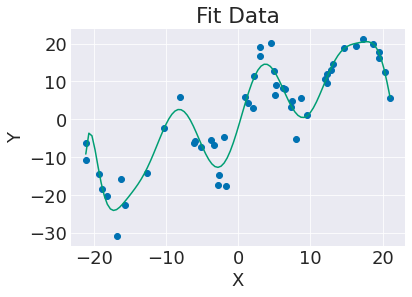

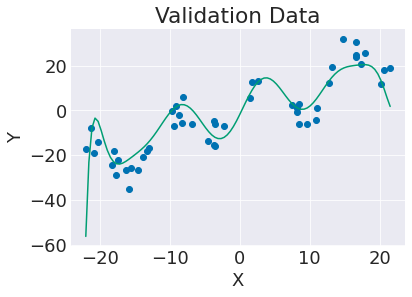

Fit R^2:  0.9315723531909681
Fit MSSE:  11.996174447006325
Validation R^2:  0.7493402881578111
Validation MSSE:  70.80321682565777


In [26]:
# make fit and validation set linear regression objects and run regression
fit_lin = linear_regression.LinearRegression(fit)
validate_lin = linear_regression.LinearRegression(validate)
fit_lin.poly_regression("X", "Y", 15)
validate_lin.initialize(fit_lin.ind_vars[0], fit_lin.dep_var, fit_lin.slope, fit_lin.intercept, fit_lin.p)

# plot results for fit data
fit_lin.scatter("X", "Y", title="Fit Data")
plt.show()

# plot results for validation data
validate_lin.scatter("X", "Y", title="Validation Data")
plt.show()

# print statistics
print("Fit R^2: ", fit_lin.R2)
print("Fit MSSE: ", fit_lin.m_sse)
print("Validation R^2: ", validate_lin.r_squared(validate_lin.predict()))
print("Validation MSSE: ", validate_lin.mean_sse())

**Question 8:** Describe how the fitted coefficients obtained for the fit set generalize to the validation set. Do they do a good or bad job? Why?

**Question 9:** Does the generalization improve or worsen for polynomial degrees < 15? Are Back up your observations with numbers (e.g. MSSE).

**Question 10:** Are there any values/ranges of polynomial degrees that generalize acceptably to the validation set? Why do you think so?

**Question 11:** What happens when you increase the polynomial degree much above 15? Why do you think this happens? Back up your observations with numbers (e.g. MSSE).

**Answer 8:** Generally, the fitted coefficients do a good job of capturing the shape of the validation set. It is not an amazing job because the curve doesn't curve high or low enough in some places, but the curve isn't bad.

**Answer 9:** Generalization does improve when $p < 15$. You can see this above where the MSSE decreases as $p$ increased. This implies a better fit for the data.

**Answer 10:** I think based on the work I have already done that curves with polynomial degree less than 15 will improve fit for a validation set. I make this claim based on how well this worked for this problem. However, I should that this may not work well with data that fits extremely well on a line. I have a case where I have overfitted the data.

**Answer 11:** If I increase p much above 15, most likely, the curve will be overfitted. The reason is that the curve will be able to capture too many inflection. The result is that the curve will try to go through all data points and not capture the general trend.

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

**Reminder:** Give credit to all sources, including anyone that you consulted.

### 1. Your own data

- Run linear regression on datasets that interest you. Identify your hypotheses about the association between variables and test them out. Make plots and report all relevant metrics fit.

### 2. Linear regression algorithm comparison

- Compare the linear regression methods that you implemented on a dataset of your choice.
- Research and implement matrix condition number. Find a dataset with a poor matrix condition number and then compare the regression methods. Which does best and why?

### 3. Confidence intervals or other kinds of error bars on linear regression plots

- Add the option to plot 95% confidence intervals on the linear regression predictions in your plot functions (e.g. `scatter`).

### 4. Overfitting

- Run polynomial regression on other datasets. What degree polynomial works well? When do you overfit?

### 5. Stepwise linear regression

- Implement the stepwise linear regression discussed in class where you add variables to the regression model one-by-one in a greedy fashion: each variable added out of the available ones not already entered in the regression should result in the largest increase in the adjusted $R^2$ value on the validation data.